In [26]:
# %%
import pathlib
import pandas as pd
import numpy as np
from itertools import combinations
import re

# plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
import seaborn.objects as so
from seaborn import axes_style

# machine learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import (
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
    accuracy_score,
)

# stats
import statsmodels.api as sm
from statsmodels import stats as sms
import statsmodels.formula.api as smf
from scipy import stats

import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [63]:
# %%
# Parameters
DATA_DIRS = [
    "../data/10odorset_MOsubtracted_2secondsafteronset",
  
]
RNG_SEED = 1
ODOR_MAPPING = {
    3: "2-ME",
    5: "BA",
    9: "Cadverine",
    12: "IPA",
    
}



In [64]:
# %%
# Utility function for model fitting
def logistic_regression_performance(data, rng=np.random.default_rng(0)):
    """
    Fit a vanilla logistic regression and report f1 score per odor and overall accuracy score
    Fitted model is not saved or returned!

    Args:
        data: pd.DataFrame  # dataframe with columns 'odor', 'exp' and a number of 'feature' columns,
        'odor' column is the prediction target,
        columns prefixed with 'feature' will be used as predictors of the regression model,
        'exp' column is kept for record keeping purposes
        rng: numpy.random._generator.Generator  # random generator used in cross validation, fix it to reproduce the same results

    Return:
        f1score_df: pd.DataFrame  # dataframe recording cross validated f1 scores, each row is one cross validation sample
        accuracy_df: pd.DataFrame  # dataframe recording cross validated accuracy scores
    """
    # split data to X and y
    X = data.filter(like="feature").to_numpy()
    y = data.odor.to_numpy()
    # data quality control
    unique_odor, counts = np.unique(y, return_counts=True)
    assert len(np.unique(counts)) == 1, "Imbalanced experimental design!"
    assert data.exp.nunique() == 1, "More than one experiment is found!"
    assert data.isna().sum().sum() == 0, "NaN values found in dataset!"
    # log information about the dataset
    logging.info(
        "There are %d trials where %d odors are presented %d times",
        len(y),
        len(unique_odor),
        np.unique(counts)[0],
    )
    logging.info(
        "%d features were extracted from population neural responses",
        X.shape[1],
    )
    # configure model
    model = make_pipeline(
        StandardScaler(), LogisticRegression()
    )  # classification pipeline combines a standardization step (substract by mean and divide by std) and a vanilla logistic regression model
    # estimate variance of model performance through 5x2 cross validation
    cv = RepeatedStratifiedKFold(
        n_splits=2, n_repeats=5, random_state=np.random.RandomState(rng.bit_generator)
    )
    f1score = []
    accuracy = []
    true_labels = []  # List to store true labels
    pred_labels = []  # List to store predicted labels
    for train_idx, test_idx in cv.split(X, y):
        # train model on the training set
        model = model.fit(X[train_idx], y[train_idx])
        true_labels.extend(y[test_idx])
        # obtain predicted labels
        pred_labels.extend(model.predict(X[test_idx]))
        # evaluate on test set
        f1score.append(f1_score(y[test_idx], model.predict(X[test_idx]), average=None))
        accuracy.append(accuracy_score(y[test_idx], model.predict(X[test_idx])))
    f1score = np.stack(f1score)
    accuracy = np.stack(accuracy)
    f1score_df = pd.DataFrame(
        data=f1score,
        index=np.arange(f1score.shape[0]),
        columns=model.classes_,
    )
    f1score_df = pd.melt(f1score_df, var_name="odor", value_name="f1_score")
    f1score_df["odor"] = pd.Categorical(f1score_df["odor"])
    f1score_df["exp"] = data.exp.unique()[0]
    accuracy_df = pd.Series(accuracy).to_frame("accuracy")
    accuracy_df["exp"] = data.exp.unique()[0]
    return f1score_df, accuracy_df, true_labels, pred_labels



In [72]:
_data.columns

Index(['feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       ...
       'feature_324', 'feature_325', 'feature_326', 'feature_327',
       'feature_328', 'feature_329', 'odor', 'exp', 'animal', 'condition'],
      dtype='object', length=334)

In [74]:
_data.filter(like='feature')

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_320,feature_321,feature_322,feature_323,feature_324,feature_325,feature_326,feature_327,feature_328,feature_329
0,0.240656,0.145643,0.024359,0.150831,0.142045,0.132031,0.225236,0.337095,0.373498,0.201010,...,-0.062569,0.072742,0.083368,0.185732,0.143599,0.075350,0.065781,0.049470,0.037319,0.257326
1,-0.027771,-0.121597,-0.093766,-0.059125,0.180446,0.177896,0.081162,-0.084917,0.100866,0.098442,...,-0.031331,0.114312,0.330276,0.196344,0.232019,0.097017,0.036959,0.183429,0.007093,0.023761
2,-0.000076,-0.070261,0.030178,0.058151,-0.045972,-0.078500,0.009082,-0.035274,0.007721,-0.051824,...,0.434356,0.518364,0.642146,0.658098,0.589282,0.706212,0.667216,0.879392,0.847653,0.847745
3,-0.127630,-0.067702,0.364160,0.369564,0.236647,0.287188,0.176971,0.375543,0.292511,0.104310,...,-0.047280,-0.002586,0.087344,0.056520,0.238076,0.187973,0.219056,0.033364,0.161085,0.435232
4,-0.438405,-0.411481,-0.408960,-0.385433,-0.350940,-0.403544,-0.237299,-0.196498,-0.393705,-0.395952,...,-0.139788,-0.103222,-0.040677,-0.091940,-0.039635,0.184780,0.208616,0.443433,0.265587,0.334752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,0.091044,0.013975,0.090620,-0.073001,-0.046873,-0.030406,0.019225,-0.087452,-0.201778,-0.094166,...,0.243062,0.306678,0.182550,-0.012513,0.193755,0.190245,0.349396,0.339021,0.300444,0.135307
116,1.061488,1.254464,0.941126,0.904491,0.585866,0.665367,0.428583,0.697744,0.691407,0.805563,...,0.265785,0.391597,0.601700,0.424348,0.511650,0.350419,0.530346,0.417541,0.280774,0.461308
117,-0.493637,-0.163248,-0.190294,-0.034459,-0.028534,-0.428827,-0.184387,-0.294317,-0.113258,-0.344766,...,0.416275,0.438991,0.328811,0.373880,0.249048,0.333615,0.580935,0.336484,0.408048,0.033541
118,-0.101009,-0.135995,-0.169606,-0.102096,-0.151483,-0.144072,-0.200476,-0.238199,-0.250655,-0.365136,...,0.007083,-0.022881,-0.034022,-0.018506,-0.027275,-0.096818,-0.056106,-0.155797,-0.104492,-0.105893


In [92]:
# %%
# random seed used for all downstream analysis
rng = np.random.default_rng(RNG_SEED)
# load data
data = []
for d in DATA_DIRS:
    for filename in pathlib.Path(d).glob("*.csv"):
        _data = pd.read_csv(filename, header=None)  # load csv file
        _data.columns = [f"feature_{i}" for i in range(len(_data.columns) - 1)] + [
            "odor"
        ]  # rename columns
        _data["exp"] = filename.stem  # log experiment name as file name
        _data["animal"] = filename.stem.split("_")[0]
        # extract before or after condition with regex (two characters after "odor")
        _data["condition"] = re.findall(r"(?<=odor).{2}", filename.stem)[0]
        # average over time per neuron
        _data = _data.rename(columns=lambda col: col.replace('feature', 'raw_feature'))
        neuron = _data.filter(like="feature").to_numpy()
        neuron = neuron.reshape([120, -1, 30]).mean(axis=-1)
        for i, n in enumerate(neuron.T):
            _data[f'feature_{i}'] = n
        _data = _data.drop(columns=_data.filter(like="raw_feature").columns)
        
        data.append(_data)
        logging.info(f"loaded dataset: {filename}")
data = pd.concat(data)


INFO:root:loaded dataset: ../data/10odorset_MOsubtracted_2secondsafteronset/A88R1_tracesfeature_odorbfcondition_2SECAFODORONSET.csv
INFO:root:loaded dataset: ../data/10odorset_MOsubtracted_2secondsafteronset/A62Nt_tracesfeature_odorbfcondition_2SECAFODORONSET.csv
INFO:root:loaded dataset: ../data/10odorset_MOsubtracted_2secondsafteronset/A89Nt_tracesfeature_odorbfcondition_2SECAFODORONSET.csv
INFO:root:loaded dataset: ../data/10odorset_MOsubtracted_2secondsafteronset/A60Nt_tracesfeature_odorbfcondition_2SECAFODORONSET.csv
INFO:root:loaded dataset: ../data/10odorset_MOsubtracted_2secondsafteronset/A62-1_tracesfeature_odorbfcondition_2SECAFODORONSET.csv
INFO:root:loaded dataset: ../data/10odorset_MOsubtracted_2secondsafteronset/A60R1_tracesfeature_odorbfcondition_2SECAFODORONSET.csv


In [99]:
# %%
# Initialize lists to store performance metrics for all odor combinations
all_f1score_df = []
all_accuracy_df = []


for (exp, animal, condition), exp_data in data.groupby(["exp", "animal", "condition"]):
    logging.info(f"Training models for {exp}:")
    exp_data = exp_data.dropna(axis=1)  # drop feature columns containing nans
    exp_data = exp_data.query("odor != 1")  # remove odor 1
    exp_data = exp_data.query("odor != 2")  # remove odor 2
    exp_data = exp_data.query("odor != 4")  # remove odor 10
    exp_data = exp_data.query("odor != 6")  # remove odor 10
    exp_data = exp_data.query("odor != 7")  # remove odor 10
    exp_data = exp_data.query("odor != 8")  # remove odor 11
    exp_data = exp_data.query("odor != 10")  # remove odor 10
    exp_data = exp_data.query("odor != 11")  # remove odor 11
    
    exp_data["odor"] = exp_data["odor"].map(ODOR_MAPPING)  # map odor numbers to names
    exp_data["odor"] = pd.Categorical(
        exp_data["odor"], categories=ODOR_MAPPING.values()
    )
    # Loop over all possible combinations of 2 out of 4 odors
    for odor1, odor2 in combinations(exp_data.odor.unique(), 2):
        # Prepare data for logistic regression
        odor_data = exp_data.query("odor == @odor1 | odor == @odor2")
        # Get model performance using logistic_regression_performance function
        f1score_df, accuracy_df, _, _ = logistic_regression_performance(odor_data, rng)
        # Append the results to the lists
        all_f1score_df.append(
            f1score_df.assign(
                odor1=odor1,
                odor2=odor2,
                comp=f"{odor1}\n{odor2}",
                animal=animal,
                condition=condition,
            )
        )
        all_accuracy_df.append(
            accuracy_df.assign(
                odor1=odor1,
                odor2=odor2,
                comp=f"{odor1}\n{odor2}",
                animal=animal,
                condition=condition,
            )
        )

# Concatenate all results into single DataFrames
all_f1score_df = pd.concat(all_f1score_df)
all_accuracy_df = pd.concat(all_accuracy_df)
#all_accuracy_df.to_csv(
    #"../notebooks/predict_from_feature_binary_accuracy.csv", index=False
#)


INFO:root:Training models for A60Nt_tracesfeature_odorbfcondition_2SECAFODORONSET:
INFO:root:There are 20 trials where 2 odors are presented 10 times
INFO:root:21 features were extracted from population neural responses
INFO:root:There are 20 trials where 2 odors are presented 10 times
INFO:root:21 features were extracted from population neural responses
INFO:root:There are 20 trials where 2 odors are presented 10 times
INFO:root:21 features were extracted from population neural responses
INFO:root:There are 20 trials where 2 odors are presented 10 times
INFO:root:21 features were extracted from population neural responses
INFO:root:There are 20 trials where 2 odors are presented 10 times
INFO:root:21 features were extracted from population neural responses
INFO:root:There are 20 trials where 2 odors are presented 10 times
INFO:root:21 features were extracted from population neural responses
INFO:root:Training models for A60R1_tracesfeature_odorbfcondition_2SECAFODORONSET:
INFO:root:Th

In [100]:
##for10 odorset
mean_accuracy_df = (
    all_accuracy_df.groupby(["animal","comp"])["accuracy"]
    .mean()
    .reset_index()
)
# correct the odor pair order
def from_odor_to_num(odor):
    # reverse mapping of odor names to numbers
    return list(ODOR_MAPPING.keys())[list(ODOR_MAPPING.values()).index(odor)]


def from_odor_pair_to_num(odor_pair):
    # reverse mapping of odor pairs to numbers
    return "".join([str(from_odor_to_num(odor)) for odor in odor_pair.split("\n")])

all_odor_pairs = all_f1score_df["comp"].unique()
mean_accuracy_df["comp"] = pd.Categorical(
    mean_accuracy_df["comp"],
    categories=all_f1score_df["comp"].unique()[
        np.argsort([
            from_odor_pair_to_num(odor_pair)
            for odor_pair in all_f1score_df["comp"].unique()
        ])
    ],
    ordered=True,
)

<Axes: xlabel='comp', ylabel='accuracy'>

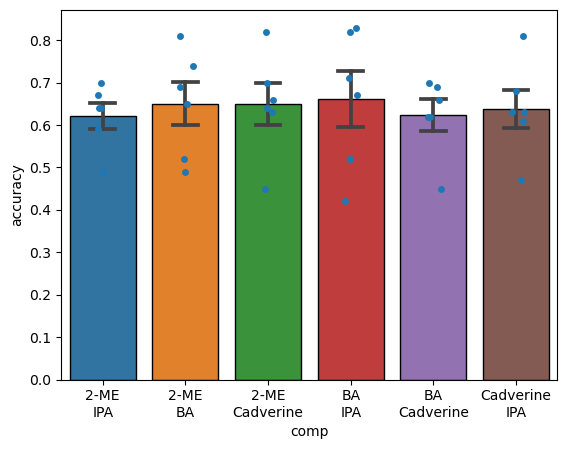

In [101]:
# %%
# visualization
sns.barplot(
    data=mean_accuracy_df,
    x="comp",
    y="accuracy",

    # add black frame around bars
    edgecolor="black",
    errorbar="se",
    # add caps to error bars
    capsize=0.3,
)
sns.stripplot(
    data=mean_accuracy_df,
    x="comp",
    y="accuracy",
  
    
    dodge=True,
)



In [102]:
mean_accuracy_df.to_csv('10odorset_compare2by2_NEUTRAL.csv', index=False)

In [103]:
mean_accuracy_df = (
    all_accuracy_df.groupby(["animal", "comp", "condition"])["accuracy"]
    .mean()
    .reset_index()
)


# correct the odor pair order
def from_odor_to_num(odor):
    # reverse mapping of odor names to numbers
    return list(ODOR_MAPPING.keys())[list(ODOR_MAPPING.values()).index(odor)]


def from_odor_pair_to_num(odor_pair):
    # reverse mapping of odor pairs to numbers
    return "".join([str(from_odor_to_num(odor)) for odor in odor_pair.split("\n")])


all_odor_pairs = all_f1score_df["comp"].unique()
mean_accuracy_df["comp"] = pd.Categorical(
    mean_accuracy_df["comp"],
    categories=all_f1score_df["comp"].unique()[
        np.argsort([
            from_odor_pair_to_num(odor_pair)
            for odor_pair in all_f1score_df["comp"].unique()
        ])
    ],
    ordered=True,
)




In [104]:
mean_accuracy_df.to_csv(
    "../notebooks/predict_from_feature_binary_accuracy_2secafodoronset_MOsubtracted_10o.csv", index=False
)



In [105]:
bfall=mean_accuracy_df.query("condition == 'bf'")["accuracy"]
afall=mean_accuracy_df.query("condition == 'af'")["accuracy"]
print(mean_accuracy_df)

   animal             comp condition  accuracy
0   A60Nt         2-ME\nBA        bf      0.65
1   A60Nt  2-ME\nCadverine        bf      0.45
2   A60Nt        2-ME\nIPA        bf      0.59
3   A60Nt    BA\nCadverine        bf      0.70
4   A60Nt          BA\nIPA        bf      0.71
5   A60Nt   Cadverine\nIPA        bf      0.47
6   A60R1         2-ME\nBA        bf      0.52
7   A60R1  2-ME\nCadverine        bf      0.70
8   A60R1        2-ME\nIPA        bf      0.64
9   A60R1    BA\nCadverine        bf      0.69
10  A60R1          BA\nIPA        bf      0.52
11  A60R1   Cadverine\nIPA        bf      0.68
12  A62-1         2-ME\nBA        bf      0.49
13  A62-1  2-ME\nCadverine        bf      0.63
14  A62-1        2-ME\nIPA        bf      0.49
15  A62-1    BA\nCadverine        bf      0.62
16  A62-1          BA\nIPA        bf      0.42
17  A62-1   Cadverine\nIPA        bf      0.63
18  A62Nt         2-ME\nBA        bf      0.69
19  A62Nt  2-ME\nCadverine        bf      0.66
20  A62Nt    

In [106]:
# %%
# stats
# Perform t-test to test whether each binary model is performing significantly better than baseline
import statsmodels.stats.api as sms
ttest_results = []
for comp, group in mean_accuracy_df.groupby("comp"):
    assert group['condition'].nunique() == 1
    ttest_results.append(
        stats.ttest_1samp(group.accuracy, 0.5)  # 0.5 is the baseline performance for a balanced binary classification problem
    )
ttest_results = pd.DataFrame(
    ttest_results, columns=["t_statistic", "p_value"], index=all_odor_pairs
)
ttest_results['p_value_adjusted'] = sms.multipletests(ttest_results.p_value, alpha=0.05, method='hs')[1]
print(ttest_results)
# ttest_results.to_csv("")

                 t_statistic   p_value  p_value_adjusted
2-ME\nBA            4.019736  0.010123          0.059224
2-ME\nCadverine     2.945521  0.032051          0.105337
2-ME\nIPA           3.061862  0.028042          0.105337
BA\nCadverine       2.416407  0.060385          0.105337
BA\nIPA             3.306736  0.021317          0.102136
Cadverine\nIPA      3.080843  0.027443          0.105337


# Below is only for comparing different conditions

In [37]:
# %%
# stats
# Perform pairwise t-tests between before and after conditions for each odor pair
ttest_results = []
for comp, group in mean_accuracy_df.groupby(["comp"]):
    bf = group.query("condition == 'bf'")["accuracy"]
    af = group.query("condition == 'af'")["accuracy"]
    ttest_results.append(
        stats.ttest_rel(bf, af)
    )  # paired t-test for before and after conditions
ttest_results = pd.DataFrame(
    ttest_results, columns=["t_statistic", "p_value"], index=all_odor_pairs
)



/tmp/ipykernel_364/289103372.py:5: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for comp, group in mean_accuracy_df.groupby(["comp"]):


ValueError: unequal length arrays

In [18]:
ttest_results = []
for comp, group in mean_accuracy_df.groupby(["comp"]):
    chance_level = np.full_like(comp, 0.5)  # Create an array of 0.5 with the same shape as bf
    ttest_results.append(
        stats.ttest_rel(comp, chance_level)
    )  # paired t-test for before and after conditions
ttest_results = pd.DataFrame(
    ttest_results, columns=["t_statistic", "p_value"], index=all_odor_pairs
)

/tmp/ipykernel_364/3471263923.py:2: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for comp, group in mean_accuracy_df.groupby(["comp"]):


UFuncTypeError: ufunc 'subtract' did not contain a loop with signature matching types (dtype('<U8'), dtype('<U8')) -> None

In [57]:
print(bf)

1     0.49
13    0.66
25    0.76
37    0.53
49    0.59
61    0.51
73    0.40
85    0.48
Name: accuracy, dtype: float64


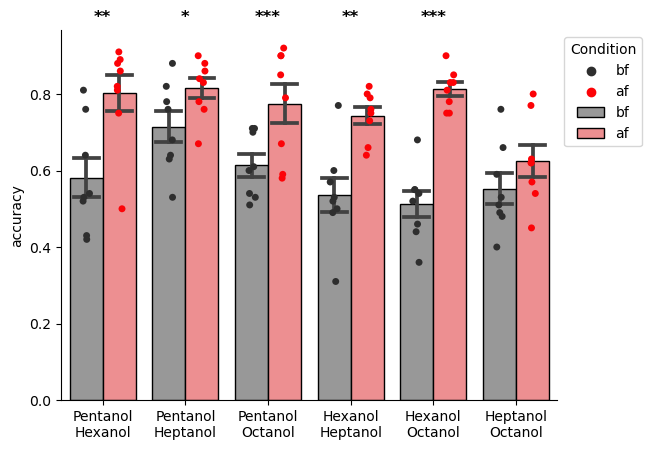

In [44]:
# %%
# visualization
# visualization
sns.barplot(
    data=mean_accuracy_df,
    x="comp",
    y="accuracy",
    hue="condition",
    # change color palette to grey and red
    palette={"bf": "#989898", "af": "#FD7F82"},
    hue_order=["bf", "af"],
    # add black frame around bars
    edgecolor="black",
    errorbar="se",
    # add caps to error bars
    capsize=0.3,
)
sns.stripplot(
    data=mean_accuracy_df,
    x="comp",
    y="accuracy",
    hue="condition",
    palette={"bf": "#2E2E2E", "af": "#FC0307"},
    hue_order=["bf", "af"],
    dodge=True,
)


def p2stars(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""


# add asterisks for significant differences
for i, (_, row) in enumerate(ttest_results.iterrows()):
    if row["p_value"] < 0.05:
        plt.text(
            i,
            1,
            p2stars(row["p_value"]),
            ha="center",
            va="center",
            color="black",
            fontsize=12,
            fontweight="bold",
        )

# legend outside of the plot
plt.legend(title="Condition", bbox_to_anchor=(1, 1), loc="upper left")
plt.xlabel("")
sns.despine()
plt.savefig(
    "../notebooks/predict_from_feature_binary_accuracy_mosubtracted.svg", dpi=300, bbox_inches="tight"
)
